In [1]:
from models.lstmautoencoder import LSTMAutoencoder
from utils.loaders import SigGenDataset
from utils.trainers import BaseTrainer
import torch
from torch.utils.data import DataLoader
import numpy as np

In [2]:
ds_name = 'DS0151'

model = LSTMAutoencoder(input_dim=1,latent_dim=128, num_layers=4, seq_length=5000).to("cuda")
filepaths = [f'./SigGen/{ds_name}_G13000771.mat',
             f'./SigGen/{ds_name}_G13000773.mat',
             f'./SigGen/{ds_name}_G13000774.mat',
             f'./SigGen/{ds_name}_G13000775.mat']
dataset = SigGenDataset(filepaths)
trainers = BaseTrainer(model)

In [4]:
from torchinfo import summary

summary(model, (10, 5000, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [10, 5000, 1]             --
├─BatchNorm1d: 1-1                       [10, 5000, 1]             10,000
├─LSTM: 1-2                              [10, 5000, 128]           463,360
├─BatchNorm1d: 1-3                       [10, 128]                 256
├─LSTM: 1-4                              [10, 5000, 1]             572
├─BatchNorm1d: 1-5                       [10, 5000, 1]             10,000
Total params: 484,188
Trainable params: 484,188
Non-trainable params: 0
Total mult-adds (G): 23.20
Input size (MB): 0.20
Forward/backward pass size (MB): 52.41
Params size (MB): 1.94
Estimated Total Size (MB): 54.55

In [3]:
model.load_state_dict(torch.load(f"{ds_name}_weights.pt"))
# model = trainers._train(train_loader = dataset, num_epochs = 10, loss_function=torch.nn.MSELoss())

<All keys matched successfully>

In [4]:
torch.save(model.state_dict(), f"{ds_name}_weights.pt")

In [5]:
latent, target = trainers.extract_latent(dataset)

Time : 5.115182306966744


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import pandas as pd

# Load or create your dataset
# Replace this with your actual data loading

# Initialize and fit k-Means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent)

# Create a confusion matrix to evaluate clustering performance
# We need to compute a mapping between cluster labels and true labels
# First, create a confusion matrix to find out how clusters are mapped to true labels
conf_matrix = confusion_matrix(target, clusters)

# Find the optimal permutation of cluster labels to match true labels
from scipy.optimize import linear_sum_assignment

# Solve the linear sum assignment problem
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

# Re-map clusters to the true labels
cluster_to_label = dict(zip(col_ind, row_ind))

# Map clusters to labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in clusters])

# Compute accuracy
accuracy = accuracy_score(target, y_pred_mapped)
print(f"Cluster Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.78


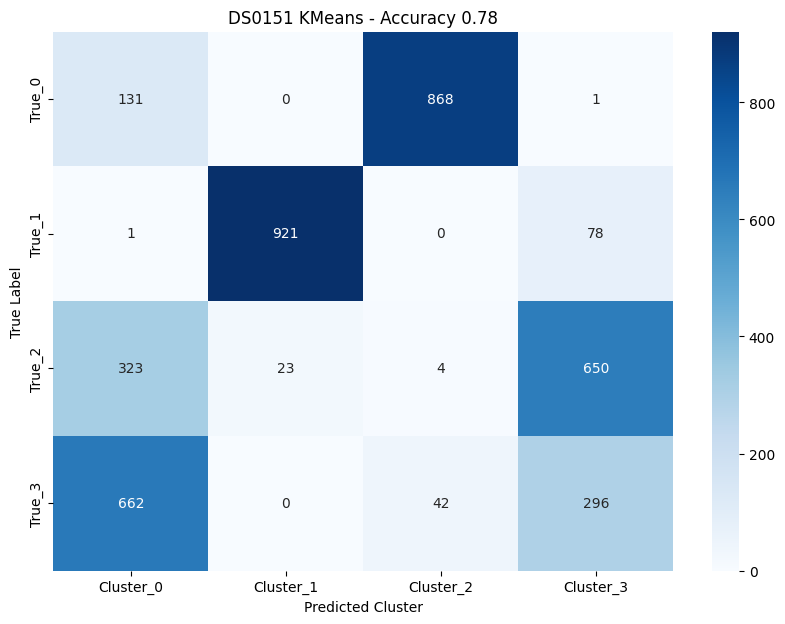

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=[f'True_{i}' for i in range(conf_matrix.shape[0])],
                              columns=[f'Cluster_{i}' for i in range(conf_matrix.shape[1])])


# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{ds_name} KMeans - Accuracy {accuracy:.2f}')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')

file_path = os.path.join('confusion_matrix', f"{ds_name}_confusion_matrix_heatmap.png")

plt.savefig(file_path, dpi=300)

plt.show()